## **OBJETIVO DEL PROYECTO**

El objetivo del proyecto es, utilizando el conjunto de Food-101 de kaggle: https://www.kaggle.com/datasets/dansbecker/food-101 ser capaz de clasificar platos de comida (concretamente las clases del dataset que son 101 tipos diferentes, sacar su valor nutricional y ofrecer una receta de ese plato. Finalmente poder utilizar el modelo a través de una API de tipo Rest utilizando Python y por supuesto redes neuronales (ya sea redes creadas por nosotros o mediante el uso de transfer learning).

Se dividirá el proyecto en 3 partes:

1. La de clasificar las imágenes
2. estimación de información nutricional y receta del plato
4. API

## **1. Clasificación de las imágenes**

Dejarémos un modelo preparado para clasificar imágenes de platos de comida

### **Importación de librerías**

Se importarán las librerías principales para desarrrollar este apartado

In [ ]:
import pandas as pd #cargar los datos y exploración
import tensorflow as tf  # para entrenamiento y predicción del modelo
from tensorflow.keras.applications import EfficientNetB0  # Modelo preentrenado para Transfer Learning
from tensorflow.keras.models import Model, load_model  # Creación y carga de modelos que nos vendrá bien para la inferencia del mismo
from tensorflow.keras.layers import Dense, Dropout, Flatten,GlobalAveragePooling2D, Conv2D, MaxPooling2D  # Capas de la red neuronal que se usarán
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Preprocesamiento de imágenes padra data argumentation
import numpy as np  # operaciones matemáticas eficientes y rápidas
import matplotlib.pyplot as plt #para visualización de imágenes o datos
import os


import warnings
warnings.filterwarnings("ignore")

### **Carga de datos**

Se cargará el dataset de food 101 de la página web original, y lo descargaremos en una carpeta creada donde también se extraerá, y para ello hay que conectarnos con nuestro google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive') #conectando con mi drive

Mounted at /content/drive


Esta celda se ejecuta para descargarlo si no lo tienes aun

In [ ]:

#ruta de mi carpeta de trabajo en Drive
ruta_destino = "/content/drive/MyDrive/tokio/deep_learning/proyecto_final_foodAi"

#Descargando Food-101
print("Descargando Food-101...")
!wget --progress=bar:force:noscroll http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz -P "{ruta_destino}"

#Extrayendo Food-101
print("Extrayendo Food-101...")
!tar --checkpoint=10000 --checkpoint-action=dot -xzf "{ruta_destino}/food-101.tar.gz" -C "{ruta_destino}"

# Elimino el .tar.gz para ahorrar espacio
print("Eliminando archivo comprimido...")
!rm "{ruta_destino}/food-101.tar.gz"

print("Proceso Terminado")

## **Análisis exploratorio de los datos**

*Verificamos algunos datos dataset después de extraerlo*

Podemos ver que al extraer el archivo contamos con cuatro archivos o carpetas:


images -->	Imágenes organizadas por clase. NO separadas en train/test.

meta -->	Archivos train.txt y test.txt que definen las particiones. (también encontramos las etiquetas del dataset)

license_agreement.txt	que es la información legal del dataset.

README.txt	Explicación oficial sobre cómo usar el dataset.

Vamos a echarlas un vistazo

In [ ]:
ruta_dataset = f"{ruta_destino}/food-101"
print("Carpetas principales:", os.listdir(ruta_dataset))


Carpetas principales: ['images', 'meta', 'license_agreement.txt', 'README.txt']


Con este bloque de código vemos algunos ejemplos de tipos de comida que nos encontraremos en el dataset

In [ ]:
print("Ejemplo de clases:", os.listdir(os.path.join(ruta_dataset, "images"))[:10])


Ejemplo de clases: ['beignets', 'prime_rib', 'ramen', 'hamburger', 'bruschetta', 'chicken_wings', 'pork_chop', 'greek_salad', 'sashimi', 'risotto']


Vemos que tenemos un dataset balanceado de manera perfecta ya que nos dice que tenemos 1000 imágenes por clase

In [ ]:
print("Número de imágenes por clase:")
for folder in os.listdir(os.path.join(ruta_dataset, "images")):
    print(f"{folder}: {len(os.listdir(os.path.join(ruta_dataset, 'images', folder)))}")


Número de imágenes por clase:
beignets: 1000
prime_rib: 1000
ramen: 1000
hamburger: 1000
bruschetta: 1000
chicken_wings: 1000
pork_chop: 1000
greek_salad: 1000
sashimi: 1000
risotto: 1000
pizza: 1000
eggs_benedict: 1000
guacamole: 1000
chocolate_cake: 1000
miso_soup: 1000
apple_pie: 1000
fried_calamari: 1000
fried_rice: 1000
panna_cotta: 1000
hummus: 1000
carrot_cake: 1000
beet_salad: 1000
garlic_bread: 1000
hot_dog: 1000
steak: 1000
tiramisu: 1000
fish_and_chips: 1000
caesar_salad: 1000
tuna_tartare: 1000
pancakes: 1000
chocolate_mousse: 1000
lasagna: 1000
pad_thai: 1000
cheesecake: 1000
baklava: 1000
ice_cream: 1000
red_velvet_cake: 1000
tacos: 1000
foie_gras: 1000
grilled_cheese_sandwich: 1000
frozen_yogurt: 1000
seaweed_salad: 1000
breakfast_burrito: 1000
crab_cakes: 1000
strawberry_shortcake: 1000
beef_tartare: 1000
mussels: 1000
dumplings: 1000
creme_brulee: 1000
falafel: 1000
scallops: 1000
oysters: 1000
samosa: 1000
club_sandwich: 1000
french_fries: 1000
chicken_quesadilla: 100

Vemos el número de clases que hay en el dataset que es de 101 tipos de comida diferentes. Obviamente no contamos con todos los ejemplos posibles del mundo y que es probable que de cara a sacar el modelo a producción no sepa reconocer algunas comidas ya que 101 no son todas las que existen ni por asomo en el mundo


In [ ]:
len(os.listdir(os.path.join(ruta_dataset, "images")))

101

Contamos con un total de 101000 imágenes, un número bastante potente para poder obtener un buen modelo y unas buenas predicciones al contar con bastantes ejemplos de cada tipo

In [ ]:
#Total imágenes
total_imagenes = sum([len(files) for _, _, files in os.walk(os.path.join(ruta_dataset, "images"))])
print(f"Total de imágenes en el dataset: {total_imagenes}")


Total de imágenes en el dataset: 101000


Vamos a elegir algunas imágenes random del dataset y compararlas con el tipo de comida al que pertenecen. Esta celda se puede ejecutar las veces que uno quiera para ir viendo diferentes ejemplos.



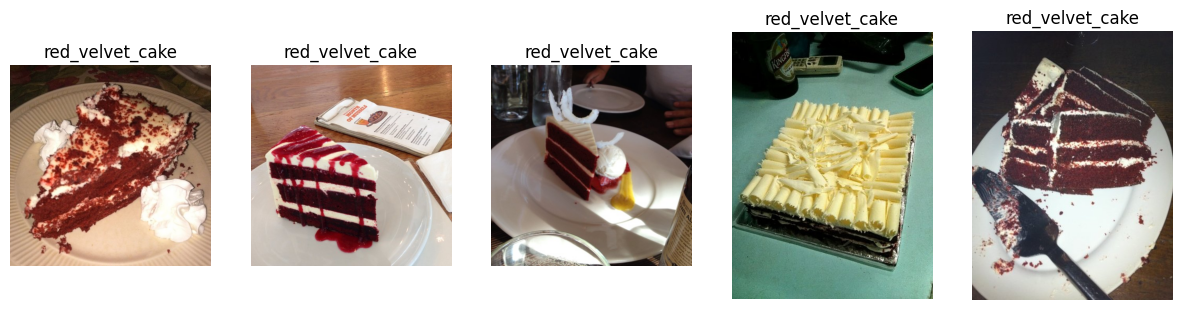

In [ ]:

import random
from PIL import Image

# Seleccionamos una clase aleatoria
clases = os.listdir(os.path.join(ruta_dataset, "images"))
clase_aleatoria = random.choice(clases)
ruta_clase = os.path.join(ruta_dataset, "images", clase_aleatoria)

# Volvemos de manera aleatoria a seleccionar imágenes esa clase
imagenes = os.listdir(ruta_clase)
imagenes_aleatorias = random.sample(imagenes, 5)

# Mostrando las imágenes
fig, axs = plt.subplots(1, 5, figsize=(15,5))
for i, img in enumerate(imagenes_aleatorias):
    img_path = os.path.join(ruta_clase, img)
    axs[i].imshow(Image.open(img_path))
    axs[i].axis("off")
    axs[i].set_title(clase_aleatoria)
plt.show()

## **TRAIN Y TEST**

Ahora que hemos analizado un poco el dataset que nos vamos a encontrar vamos a coger el train y test que viene ya dado por la página oficial por varias razones:

1. Ya tiene una división oficial en meta/train.txt y meta/test.txt.

2. La partición es la misma que se usa en los papers, lo que permite comparar resultados con estudios previos.

3. Evitamos hacer particiones manuales.


Para ello vamos a convertir train.txt y test.txt en carpetas separadas (train/ y test/). Después volveremos a repetir el análisis exploratorio de datos con estas divisiones y verificaremos los formatos, tamaños de imagenes, estructura, y clases


### División de train y test en carpetas separadas

ImageDataGenerator.flow_from_directory() para el data argumentation necesita las imágenes organizadas en carpetas, no en un .txt.

La ventaja de hacerlo de esta manera es que al ser compatible con flow_from_directory es más facil de entrenary permite aplicar data argumentation aunque solo a la parte del train claro. También evita leer y cargar manualmente train.txt y test.txt cada vez.


In [ ]:
import shutil #libreria para copiar las imagenes de manera recursiva

ruta_images = os.path.join(ruta_dataset, "images")
ruta_meta = os.path.join(ruta_dataset, "meta")

# Las rutas destino para train y test
ruta_train = os.path.join(ruta_dataset, "train")
ruta_test = os.path.join(ruta_dataset, "test")

# Creamos las carpetas si no existen
os.makedirs(ruta_train, exist_ok=True)
os.makedirs(ruta_test, exist_ok=True)

# Aqui copiamos las imágenes a sus carpetas correspondientes
def copiar_imagenes(txt_file, destino):
    with open(txt_file, "r") as f:
        lineas = f.read().splitlines()

    for linea in lineas:
        clase, img_name = linea.split("/")
        src_path = os.path.join(ruta_images, clase, img_name + ".jpg")
        dest_dir = os.path.join(destino, clase)
        os.makedirs(dest_dir, exist_ok=True)  # si no existe la carpeta me la creo
        shutil.copy(src_path, dest_dir)


print("Copiando imágenes del entrenamiento...")
copiar_imagenes(os.path.join(ruta_meta, "train.txt"), ruta_train)

print("Copiando las imágenes de prueba...")
copiar_imagenes(os.path.join(ruta_meta, "test.txt"), ruta_test)

print("Carpetas train y test creadas correctamente")


Copiando imágenes del entrenamiento...
Copiando las imágenes de prueba...
Carpetas train y test creadas correctamente


## **Análisis exploratorio de train y test**

### Verificamos la estructura de cada división

In [ ]:
# Contamos las imágenes en train y test con esta función
def contar_imagenes(ruta):
    conteo = {clase: len(os.listdir(os.path.join(ruta, clase))) for clase in os.listdir(ruta)}
    total = sum(conteo.values())
    return conteo, total

conteo_train, total_train = contar_imagenes(ruta_train)
conteo_test, total_test = contar_imagenes(ruta_test)

print(f"Total imagenes en Train: {total_train}")
print(f"Total imagenes en Test: {total_test}")


Total imagenes en Train: 75750
Total imagenes en Test: 25250


### Visualizamos imágenes aleatóricas de train



Imágenes aleatorias de Train:


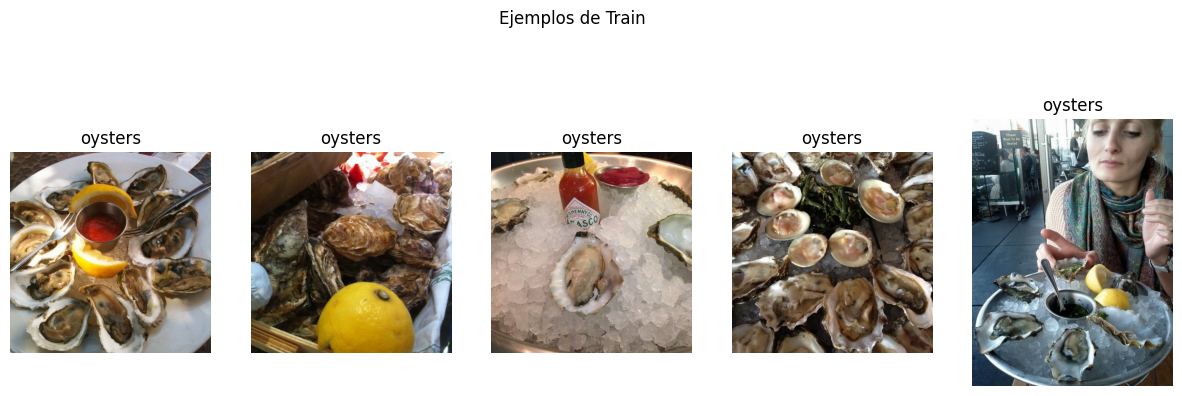


Imágenes aleatorias de Test:


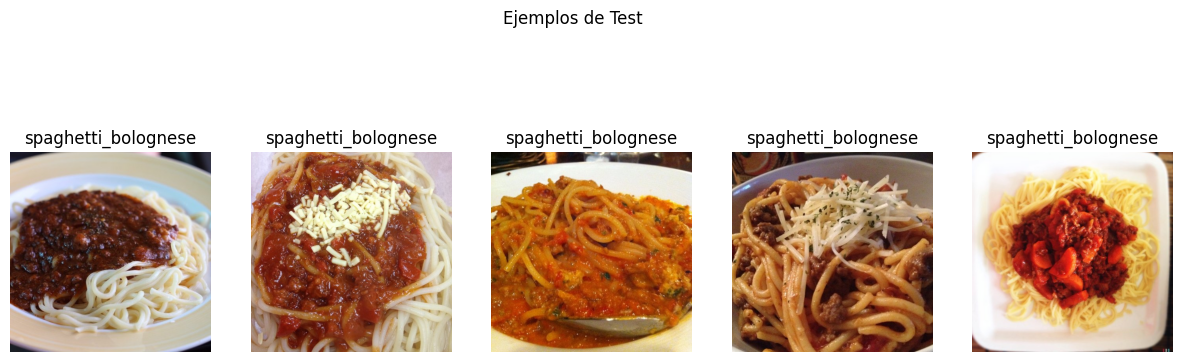

In [ ]:
ruta_train = "/content/drive/MyDrive/tokio/deep_learning/proyecto_final_foodAi/food-101/train"
ruta_test = "/content/drive/MyDrive/tokio/deep_learning/proyecto_final_foodAi/food-101/test"

def visualizar_imagenes_aleatorias(ruta, titulo):
    clases = os.listdir(ruta)
    clase_aleatoria = random.choice(clases)  # una clase aleatoria
    ruta_clase = os.path.join(ruta, clase_aleatoria)
    imagenes_aleatorias = random.sample(os.listdir(ruta_clase), 5)  # Selecciono 5 imágenes

    # Grafica
    fig, axs = plt.subplots(1, 5, figsize=(15, 5))
    for i, img in enumerate(imagenes_aleatorias):
        img_path = os.path.join(ruta_clase, img)
        axs[i].imshow(Image.open(img_path))
        axs[i].axis("off")
        axs[i].set_title(clase_aleatoria)

    plt.suptitle(titulo)
    plt.show()

# Visualizo las imágenes aleatorias en Train y Test
print("\nImágenes aleatorias de Train:")
visualizar_imagenes_aleatorias(ruta_train, "Ejemplos de Train")

print("\nImágenes aleatorias de Test:")
visualizar_imagenes_aleatorias(ruta_test, "Ejemplos de Test")


### Verificamos el balanceo de las clases

Distribución de imágenes en Train:


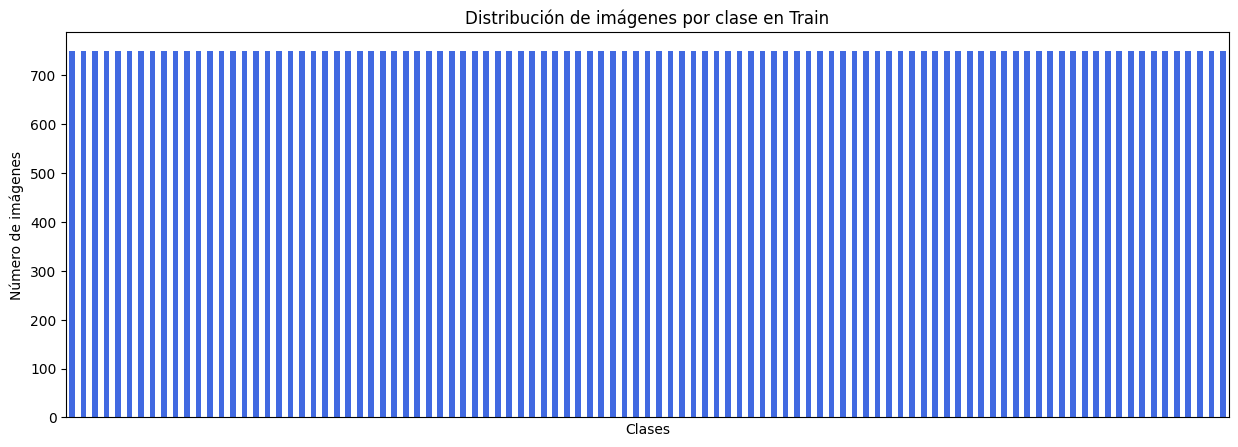


Distribución de imágenes en Test:


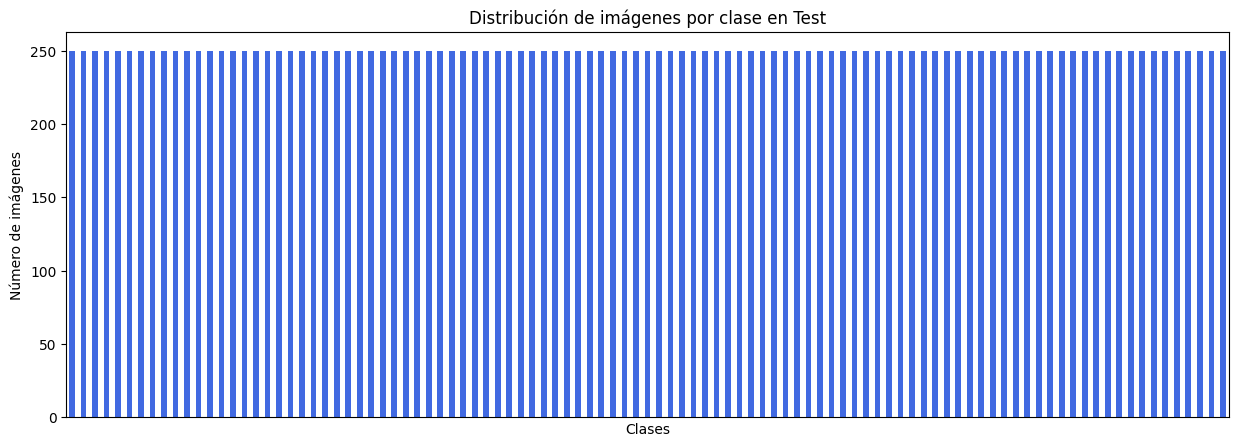

In [ ]:
def graficar_balanceo(conteo, titulo):
    df = pd.DataFrame.from_dict(conteo, orient="index", columns=["Cantidad"])
    df = df.sort_values("Cantidad", ascending=False)

    # Grafico de la distribución
    plt.figure(figsize=(15, 5))
    df["Cantidad"].plot(kind="bar", color="royalblue")
    plt.xlabel("Clases")
    plt.ylabel("Número de imágenes")
    plt.title(titulo)
    plt.xticks([])
    plt.show()

#distribución de clases en Train y Test
print("Distribución de imágenes en Train:")
graficar_balanceo(conteo_train, "Distribución de imágenes por clase en Train")

print()

print("Distribución de imágenes en Test:")
graficar_balanceo(conteo_test, "Distribución de imágenes por clase en Test")

Todas las clases estan balanceadas en ambos conjuntos, por lo que nos hace confiar más en que elegimos bien al quedarnos con el train y test de los creadores

### Comprobación de mismos formatos, tamaño de las imagenes o imágenes corruptas

Verificamos si las imágenes están en el mismo tamaño para evitar errores en el modelo. Además todas deben ser JPEG que evita problemas de compatibilidad. Miraremos eso también y si hay alguna imágen corrupta eliminarlas para evitar fallos. Lo haremos en ambos conjuntos para:

En train: garantizar que el modelo aprenda con imágenes uniformes.
En test: la evaluación tiene que ser confiable y sin errores.



In [ ]:
from collections import Counter

def analizar_formato_y_tamano(ruta):
    formatos = []
    tamanos = []
    errores = []

    for clase in os.listdir(ruta):  # Recorremos cada clase
        clase_path = os.path.join(ruta, clase)
        if not os.path.isdir(clase_path):  # Saltamos archivos sueltos
            continue
        for img_name in os.listdir(clase_path):
            img_path = os.path.join(clase_path, img_name)
            try:
                with Image.open(img_path) as img:
                    formatos.append(img.format)  # Guardamos el formato
                    tamanos.append(img.size)  # Guardamos el tamaño
            except Exception as e:
                errores.append(img_path)  # Imagen corrupta


    print(f"Analizando: {ruta}")
    print(f"Formatos encontrados: {dict(Counter(formatos))}")
    print(f"Tamaños de imagen más comunes: {dict(Counter(tamanos).most_common(5))}")
    print(f"Imágenes corruptas encontradas: {len(errores)}")

    if errores:
        print("Ejemplo de imágenes corruptas:", errores[:5])

# Aplico la función a Train y Test
print("Verificando Train...")
analizar_formato_y_tamano(ruta_train)

print("\nVerificando Test...")
analizar_formato_y_tamano(ruta_test)


Verificando Train...
Analizando: /content/drive/MyDrive/tokio/deep_learning/proyecto_final_foodAi/food-101/train
Formatos encontrados: {'JPEG': 75750}
Tamaños de imagen más comunes: {(512, 512): 46688, (512, 384): 10979, (384, 512): 4864, (382, 512): 2171, (512, 382): 1876}
Imágenes corruptas encontradas: 0

Verificando Test...
Analizando: /content/drive/MyDrive/tokio/deep_learning/proyecto_final_foodAi/food-101/test
Formatos encontrados: {'JPEG': 25250}
Tamaños de imagen más comunes: {(512, 512): 15518, (512, 384): 3812, (384, 512): 1654, (382, 512): 708, (512, 382): 636}
Imágenes corruptas encontradas: 0


Parece que todas la imágenes están en el formato adecuado (jpeg) y no se han encontrado imágenes corruptas. Lo que si que hay diferentes tamaños de imagen que luego modificaremos en el preprocesamiento ya que el modelo debe recibir el mismo tamaño para todas las imágenes.

A pesar de que en general el dataset esta bastante bien prepradado, es el análisis estándar que todo dataset de imágenes debe tener ya que en el mundo real no van a ser los dataset tan perfectos.

## **Preprocesamiento de las imágenes**

### **Redimensión de imagenes**

En este bloque de código crearemos una nueva carpeta paraalmacenar las imágenes redimensionadas y separar y organizar los archivos.
Recorreremos todas las imágenes en train/ y test/ y redimensionaremos cada imagen en 224X224 para que tengan un tamaño uniforme para el modelo.

Manejaremos posibles errores si alguna imagen tiene problemas al abrirse, la salta y muestra un mensaje de error.

Algunas imágenes pueden estar en otros modos de color (RGBA, P, L, etc.). En RGBA significa que la imagen tiene transparencias, y si la intentamos guardar sin convertir, podemos tener un error o una imagen negra.


Añadiremos que si la imagen ya está en RGB, no cambia nada. Si la imagen tiene transparencia (RGBA), la convierte para evitar errores.

In [ ]:

ruta_salida = "/content/drive/MyDrive/tokio/deep_learning/proyecto_final_foodAi/food-101-preprocesado"

# Creo las carpetas para train y test en el nuevo dataset
for tipo in ["train", "test"]:
    ruta_tipo = os.path.join(ruta_salida, tipo)
    os.makedirs(ruta_tipo, exist_ok=True)

    for clase in os.listdir(os.path.join(ruta_dataset, tipo)):
        os.makedirs(os.path.join(ruta_tipo, clase), exist_ok=True)

#Función para redimensionar imágenes y manejar errores
def procesar_imagenes(ruta_origen, ruta_destino, tamaño=(224, 224)):
    for tipo in ["train", "test"]:
        ruta_tipo = os.path.join(ruta_origen, tipo)
        for clase in os.listdir(ruta_tipo):
            ruta_clase = os.path.join(ruta_tipo, clase)
            for img_name in os.listdir(ruta_clase):
                img_path = os.path.join(ruta_clase, img_name)
                img_salida_path = os.path.join(ruta_destino, tipo, clase, img_name)

                try:
                    with Image.open(img_path) as img:
                        img = img.convert("RGB")  #  a RGB para evitar errores con transparencias
                        img = img.resize(tamaño, Image.LANCZOS)  # Redimensiono sin distorsión
                        img.save(img_salida_path)  # Guardo con el mismo formato original
                except Exception as e:
                    print(f"Error con la imagen {img_path}: {e}")
                    continue  # Salto la imagen y continuar con la siguiente


print("Procesando imágenes...")
procesar_imagenes(ruta_dataset, ruta_salida)
print("Preprocesamiento completado. Imágenes guardadas en:", ruta_salida)


Procesando imágenes...
Preprocesamiento completado. Imágenes guardadas en: /content/drive/MyDrive/tokio/deep_learning/proyecto_final_foodAi/food-101-preprocesado


Verificamos que efectivamente se a cumplido el preprocesamiento

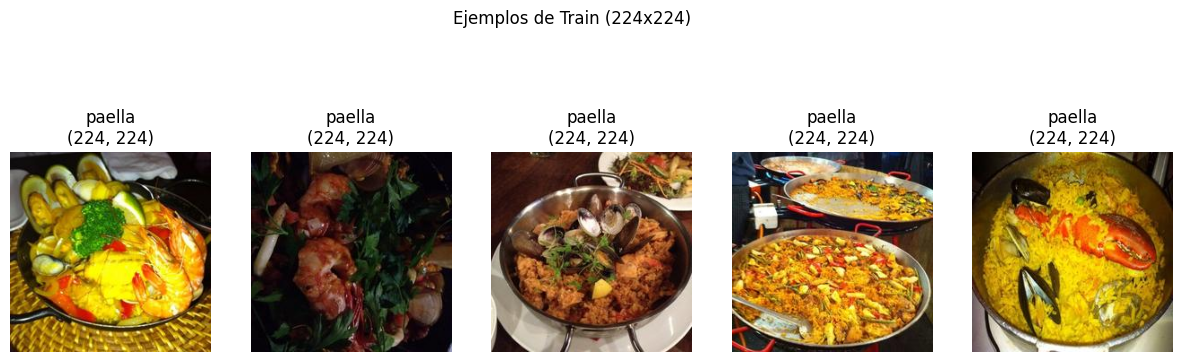

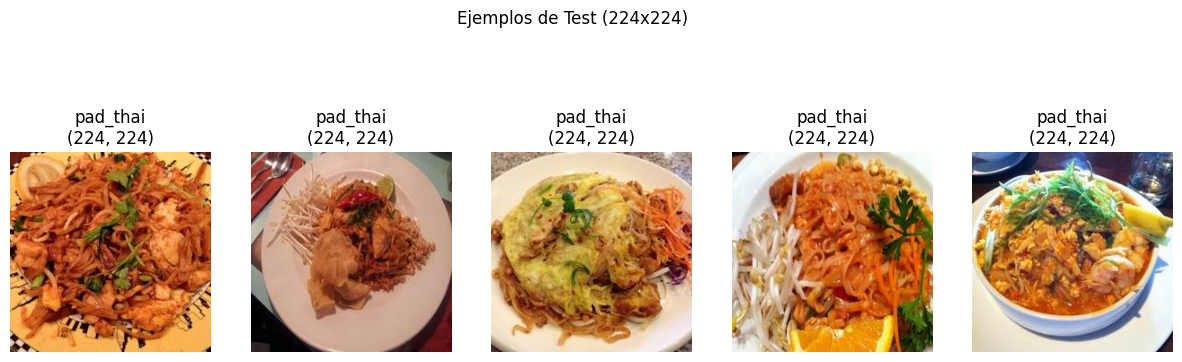

In [ ]:

ruta_preprocesada = "/content/drive/MyDrive/tokio/deep_learning/proyecto_final_foodAi/food-101-preprocesado"

#Función para verificar imágenes aleatorias
def verificar_imagenes_aleatorias(ruta, titulo):
    clases = os.listdir(ruta)
    clase_aleatoria = random.choice(clases)  # una clase aleatoria
    ruta_clase = os.path.join(ruta, clase_aleatoria)
    imagenes_aleatorias = random.sample(os.listdir(ruta_clase), 5)  # Tomamos 5 imágenes

    # Grafico las imágenes
    fig, axs = plt.subplots(1, 5, figsize=(15, 5))
    for i, img_name in enumerate(imagenes_aleatorias):
        img_path = os.path.join(ruta_clase, img_name)
        with Image.open(img_path) as img:
            axs[i].imshow(img)
            axs[i].axis("off")
            axs[i].set_title(f"{clase_aleatoria}\n{img.size}")  # Muestra la clase y tamaño

    plt.suptitle(titulo)
    plt.show()

#Verificamos imágenes de Train y Test preprocesadas

verificar_imagenes_aleatorias(os.path.join(ruta_preprocesada, "train"), "Ejemplos de Train (224x224)")


verificar_imagenes_aleatorias(os.path.join(ruta_preprocesada, "test"), "Ejemplos de Test (224x224)")


## **Antes de nada y algo muy importante, es copiar el dataset a la Ram de colab para acelerar la carga de imágenes ya que tenemos muchas y tardaría una eternidad el entrenamiento**

In [4]:
#Copio dataset a RAM de Colab para acelerar la carga de imágenes
!cp -r "/content/drive/MyDrive/tokio/deep_learning/proyecto_final_foodAi/food-101-preprocesado" /content/
ruta_dataset = "/content/food-101-preprocesado"

###**Reducción del dataset**


Después de probar con todo el conjunto, usando la GPU de colab no es suficiente para entrenar toda la cantidad de imagenes que disponemos, por falta de recursos y de tiempo. El entrenamiento se hace muy lento,  asique vamos a reducir el dataset a la mitad y si tenemos más tiempo se puede aumentar sin problemas

In [8]:
import shutil

#Rutas de momento
ruta_origen = "/content/drive/MyDrive/tokio/deep_learning/proyecto_final_foodAi/food-101-preprocesado" #donde tenemos el dataset preprocesado
ruta_ram = "/content/food-101-preprocesado"  # Copia completa en RAM
ruta_reducida = "/content/food-101-reducido"  #Dataset reducido al 50%

# Creo carpeta para el dataset reducido
if not os.path.exists(ruta_reducida):
    os.makedirs(os.path.join(ruta_reducida, "train"), exist_ok=True)
    os.makedirs(os.path.join(ruta_reducida, "test"), exist_ok=True)

# Aqui selecciono solo el 50% del dataset total manteniendo la proporción 75% train / 25% test
for tipo in ["train", "test"]:
    ruta_original = os.path.join(ruta_ram, tipo)
    ruta_destino = os.path.join(ruta_reducida, tipo)

    for clase in os.listdir(ruta_original):
        ruta_clase_original = os.path.join(ruta_original, clase)
        ruta_clase_destino = os.path.join(ruta_destino, clase)

        os.makedirs(ruta_clase_destino, exist_ok=True)

        imagenes = os.listdir(ruta_clase_original)
        random.shuffle(imagenes)  #Mezclo aleatoriamente las imágenes

        num_total = len(imagenes)
        num_a_copiar = num_total // 2  # importante  donde selecciono el 50% de imágenes

        # Copio solo el 50% de imágenes de cada clase
        for img in imagenes[:num_a_copiar]:
            shutil.copy(os.path.join(ruta_clase_original, img), os.path.join(ruta_clase_destino, img))

print("Reducción del dataset completada.")

Reducción del dataset completada.


### **Normalización de imágenes y data argumentation**

 Convertiremos los valores de píxeles de 0-255 a 0-1 para mejorar el rendimiento del modelo.
además de añadir nuevas imágenes solo en train (data argumentation) aplicando transformaciones como rotaciones, desplazamientos y zoom para evitar sobreajuste y mejorar la generalización.

No se aplica Data Augmentation en test porque el conjunto de prueba debe mantenerse sin modificaciones para evaluar el rendimiento real del modelo.

También estableceré un tamaño de imagen de 160x 160, más bajito que el original que tenía d enuevo para acelerar algo más el proceso al no haber tantos cálculos

In [9]:

#Data Augmentation solo para entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,  # Rotación aleatoria hasta 15°
    width_shift_range=0.1,  #Desplazamiento horizontal (10%)
    height_shift_range=0.1,  # Desplazamiento vertical (10%)
    shear_range=0.1,  # Transformación de corte
    zoom_range=0.1,  # Zoom aleatorio hasta 10%
    horizontal_flip=True,  #Volteo horizontal
    fill_mode="nearest"
)

# Normalización sin Data Augmentation para test
test_datagen = ImageDataGenerator(rescale=1./255)

# Cargo las imágenes para entrenamiento desde el dataset reducido
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(ruta_reducida, "train"),
    target_size=(198, 198),
    batch_size=64,
    class_mode="categorical"
)

# Cargo imágenes para validación desde el dataset reducido
test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(ruta_reducida, "test"),
    target_size=(198, 198),
    batch_size=64,
    class_mode="categorical"
)

#compruebo los cambios
print(f"Train: {train_generator.samples} imágenes con Data Augmentation")
print(f"Test: {test_generator.samples} imágenes solo Normalizadas")

Found 37875 images belonging to 101 classes.
Found 12625 images belonging to 101 classes.
Train: 37875 imágenes con Data Augmentation
Test: 12625 imágenes solo Normalizadas


## **Construcción del modelo desde 0**

Despues del preprocesamiento toca construir el modelo que hará la predicción de imágenes. El lema aquí es si nos conviene hacer el modelo desde 0 o utilizaremos un modelo preentrenado que al ya venir entrenado con anterioridad el proceso sería menos lento y costoso.

Podríamos crear ambos modelos y más o menos hacernos una idea de cuanto tardaría cada uno

Definiré primero un modelo convolucional con tres capas convolucionales ya que tiene que capturar muchos datos y a cada capa le voy agregando cada vez más filtros buscando cada vez ue sea más preciso. Agrego una capa de pooling a todas para ir reducciendo un poco la dimensionalidad y el posible sobreajuste, evitando mucho coste y poca generalización.

In [10]:

from tensorflow.keras.models import Sequential


#Defino el modelo CNN desde cero
modelo_cnn = Sequential([
    # Primera capa convolucional
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2,2)),

    # Segunda capa convolucional
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    # Tercera capa convolucional
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    # Aplano los vectores y conecto con la capa densa ue haga más cálculos
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),  # Evita sobreajuste
    Dense(101, activation='softmax')  # 101 neuronas por cada número de clases a predecir
])

#Compilo el modelo
modelo_cnn.compile(
    optimizer='adam',#por elegir una (aunque podría haber elegido SGD)
    loss='categorical_crossentropy', #para la clasificacion multiclase
    metrics=['accuracy'] #accuracy por el balanceo de clases
)



## **Con modelo preentrenado**

Una de las cosas más interesantes que podemos hacer, en vez de construir un modelo desde cero, es construir un modelo preentrenado o ya existente, que se entrenó en su momento para un problema pero que con su arquitectura de capas y parámetros podemos adaptarlo a nuestro problema. Además, al estar preentrenado, no tenemos que empezar a enttenar todo desde cero y supone más rapidez que nos vendra bien ya que contamos con muchos datos, y ya se puede intuir que necesitaremos muchas horas para construirlo desde cero.

Una de las cosas interesantes es que podemos elegir cuantas capas podemos congelar del modelo preentrenado. Es decir, cuantas más capas congelemos (en este caso congelamos solo las primeras 100 capas), más conservamos el conocimiento aprendido por el modelo preentrenado, lo que es útil cuando nuestro nuevo conjunto de datos es similar al original con el que fue entrenado. Sin embargo, al dejar las capas finales entrenables, permitimos que el modelo se adapte mejor a las características específicas de nuestro problema, ajustando los patrones de alto nivel que diferencian las clases de nuestro dataset. Esto logra un equilibrio entre reutilizar el conocimiento previo y adaptar el modelo a nuestra tarea sin necesidad de entrenarlo completamente desde cero.

Utilizaremos el modelo preentrenado Mobilenet diseñado para ser eficiente en dispositivos con recursos limitados, donde en este caso tenemos un dataset enorme, y contamos con la cpu de colab, alternando con la gpu. Lo cual nos vendrá bien.

En nuestro caso, lo configuramos con include_top=False para eliminar la capa de clasificación original y agregar nuestras propias capas densas adaptadas a las 101 clases de nuestro dataset.

En cuanto al resto de capas:

-GlobalAveragePooling2D() :Reduce cada mapa de características a un único valor promedio por canal, comprimiendo la información sin necesidad de capas densas grandes, lo que ayudará a evitar el sobreajuste.

-Dense(256, activation="relu"): Capa densa con 256 neuronas para aprender patrones avanzados antes de la clasificación final

-Dropout(0.4): Queremos apaga aleatoriamente el 40% de neuronas para evitar sobreajuste.

-Por ultimo otra capa densa (101) neuronas, una por cada clase a predecir y axctivación softax para predicción multiclase










In [11]:

base_model = tf.keras.applications.MobileNetV2(input_shape=(198, 198, 3), include_top=False, weights="imagenet")
base_model.trainable = True  # 🔥 Permitimos que algunas capas se entrenen

# Congelo solo las primeras 100 capas para reutilizar características aprendidas
for layer in base_model.layers[:100]:
    layer.trainable = False

#Construyo el modelo con más capacidad de ajuste
modelo_tl1 = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(101, activation="softmax", dtype=tf.float32)
])



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
# parámetros entrenables y no entrenables del modelo desde cero
print("Modelo desde Cero:")
modelo_cnn.summary()

#parámetros entrenables y no entrenables del modelo con Transfer Learning
print("\nModelo con Transfer Learning:")
modelo_tl1.summary()


Modelo desde Cero:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 101)                 │          25,957 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,270,629 (84.96 MB)

 Trainable params: 22,270,629 (84.96 MB)

 Non-trainable params: 0 (0.00 B)


Modelo con Transfer Learning:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 101)                 │          25,957 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,611,877 (9.96 MB)

 Trainable params: 2,215,333 (8.45 MB)

 Non-trainable params: 396,544 (1.51 MB)

### Comparativa y elección

**Modelo CNN (desde 0)**

Este modelo tiene 22,270,629 parámetros entrenables, o sea, muchísimos más que el otro modelo preentrenado.


La capa Flatten() genera 86,528 nodos, lo que dispara el número de parámetros en la capa densa.
La capa Dense(256) aporta 22M de parámetros, lo que implica un gran consumo de memoria y cómputo.


Ventajas:

Puede aprender características específicas del dataset, sin estar limitado por los patrones de otro modelo.

Desventajas:

Es pesado (85 MB en memoria).
El entrenamiento será lento debido a la cantidad de parámetros.
Al aprender desde cero, es posible que tienda al sobreajuste (overfitting).


**Modelo con Transfer Learning (MobileNetV2)**

Este modelo tiene 2,611,877 parámetros totales (9.96 MB), o sea, mucho más ligero que el modelo desde cero.
De esos, 2,215,333 son entrenables, porque la base del modelo (MobileNetV2) se congela (base_model.trainable = False) y solo se entrena la parte superior (include_top=False).


Cosas importantes son:

Uso GlobalAveragePooling2D en lugar de Flatten(), lo que reduce muchísimo los parámetros en la capa densa.
Al reutilizar características ya aprendidas, tiende menos al sobreajuste.

Ventajas:

Mucho más rápido de entrenar (menos parámetros entrenables).
Menor consumo de RAM y GPU.
Menor riesgo de sobreajuste, porque ya fue entrenado con millones de imágenes, no solo con platos de comida.

Desventajas:

No aprende características específicas del dataset si no se ajustan bien las capas finales.





### **CON CUAL QUEDARME**?

CNN desde Cero vs	Transfer Learning
Tiempo de Entrenamiento	Muy lento //	5-10 veces más rápido
Memoria Usada	85 MB (grande)// 10 MB (pequeño)
Capacidad de Aprender desde Cero //	Solo tiene conocimientos previos
Precisión inicial baja (necesita más datos)	// Alta (usa MobileNetV2)
Overfitting	Probable // Menos probable

Al no tener demasiado tiempo y querer más eficiencia, me quedaré con el modelo de Transfer Learning (MobileNetV2), ya que irá más rápido y creo que para este problema me puede ir igual de bien.

Solo tendría que ir probando ciertos ajustes para buscar el mejor accuracy

## **Entrenamiento con mobilenet**

Para ello reiniciaré el entorno y usaré la gpu que acelerará el proceso.

####compruebo que tengo gpu

In [ ]:
import tensorflow as tf
print("✅ GPU disponible:", tf.config.list_physical_devices('GPU')) #me aseguro que uso la gpu


✅ GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


En este gran código entrenaremos el modelo de comida utilizando la arquitectura de MobileNetV2. Cargo un modelo pre-entrenado si existe (el último mejor modelo que salió) o crea uno nuevo si no hay ninguno. Luego congelo algunas capas iniciales, para que no se entrene con todo el modelo preentrenado sino que coja y aprenda de las capas densas para la clasificación. Guardo los modelos con el último mejor val_loss y esto es porque al entrenarse tanto tiempo debido al volumen de datos, puede desconectarse la sesión. Utilizo callbacks para mejorar el entrenamiento, como EarlyStopping para evitar sobreajuste, ReduceLROnPlateau para ajustar la tasa de aprendizaje, TensorBoard para visualizar el entrenamiento y ModelCheckpoint para guardar los mejores pesos del modelo. Además, guardo el historial de entrenamiento y el modelo final en Google Drive,.  En resumen, el código ajusta un modelo MobileNetV2 para clasificar imágenes de comida, se guarda el progreso y el resultado final en Drive, y se emplean técnicas para un entrenamiento robusto y eficiente.

In [ ]:

import json #para guardar el historial de entrenamiento en formato json
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint, Callback

# La ruta del checkpoint y del historial en Google Drive
ruta_guardado = "/content/drive/MyDrive/mobilenet_food101_checkpoint.h5"
ruta_historial = "/content/drive/MyDrive/mobilenet_food101_historial.json"

#Callback para guardar historial después de cada época
class GuardarHistorialCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        # Si ya hay historial previo, cargarlo y actualizarlo
        if os.path.exists(ruta_historial):
            with open(ruta_historial, "r") as f:
                historial_guardado = json.load(f)
        else:
            historial_guardado = {}

        # Guardo métricas de la época actual
        for key, value in logs.items():
            if key in historial_guardado:
                historial_guardado[key].append(value)
            else:
                historial_guardado[key] = [value]

        # Guardar historial actualizado en Google Drive
        with open(ruta_historial, "w") as f:
            json.dump(historial_guardado, f)
        print(f"Historial actualizado en Drive después de la época {epoch + 1}")

# Si existe un checkpoint, cargarlo. Si no, entrenar modelo desde cero.
if os.path.exists(ruta_guardado):
    print("Checkpoint encontrado. Cargando modelo de nuevo...")
    modelo_tl1 = tf.keras.models.load_model(ruta_guardado)

    # Se vuelve a compilar el modelo (evita error de métricas no construidas)
    modelo_tl1.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

else:
    print("No se encontró checkpoint. Creando un nuevo modelo desde cero...")

    # Cargo MobileNetV2 y descongelo últimas capas
    base_model = tf.keras.applications.MobileNetV2(input_shape=(198, 198, 3), include_top=False, weights="imagenet")
    base_model.trainable = True  # 🔥 Entrenamos algunas capas

    #Congelo solo las primeras 100 capas, dejando el resto entrenable
    for layer in base_model.layers[:100]:
        layer.trainable = False

    # Construyo el modelo con más capacidad de ajuste
    modelo_tl1 = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(101, activation="softmax", dtype=tf.float32)
    ])

    # Compilo modelo desde cero
    modelo_tl1.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

# Callbacks para mejorar entrenamiento
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=0.00001)
tensorboard_callback = TensorBoard(log_dir="/content/logs1", histogram_freq=1)
checkpoint = ModelCheckpoint(
    ruta_guardado, monitor="val_loss", save_best_only=True, mode="min", verbose=1
)
guardar_historial_callback = GuardarHistorialCallback()

# Continuo entrenamiento
historial_tl1 = modelo_tl1.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr, tensorboard_callback, checkpoint, guardar_historial_callback]
)

#Guardo el modelo final en Google Drive
modelo_tl1.save("/content/drive/MyDrive/mobilenet_food101_final.h5")
print("Modelo final guardado exitosamente.")


Checkpoint encontrado. Cargando modelo de nuevo...


Epoch 1/30
592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.7890 - loss: 0.8066
Epoch 1: val_loss improved from inf to 1.59339, saving model to /content/drive/MyDrive/mobilenet_food101_checkpoint.h5


Historial actualizado en Drive después de la época 1
592/592 ━━━━━━━━━━━━━━━━━━━━ 423s 665ms/step - accuracy: 0.7890 - loss: 0.8066 - val_accuracy: 0.6607 - val_loss: 1.5934 - learning_rate: 0.0010
Epoch 2/30
592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.8061 - loss: 0.7151
Epoch 2: val_loss did not improve from 1.59339
Historial actualizado en Drive después de la época 2
592/592 ━━━━━━━━━━━━━━━━━━━━ 375s 633ms/step - accuracy: 0.8061 - loss: 0.7152 - val_accuracy: 0.6501 - val_loss: 1.6472 - learning_rate: 0.0010
Epoch 3/30
592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.8218 - loss: 0.6502
Epoch 3: val_loss improved from 1.59339 to 1.47485, saving model to /content/drive/MyDrive/mobilenet_food101_checkpoint.h5


Historial actualizado en Drive después de la época 3
592/592 ━━━━━━━━━━━━━━━━━━━━ 375s 634ms/step - accuracy: 0.8217 - loss: 0.6503 - val_accuracy: 0.6697 - val_loss: 1.4749 - learning_rate: 0.0010
Epoch 4/30
592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.8297 - loss: 0.6042
Epoch 4: val_loss did not improve from 1.47485
Historial actualizado en Drive después de la época 4
592/592 ━━━━━━━━━━━━━━━━━━━━ 371s 627ms/step - accuracy: 0.8297 - loss: 0.6043 - val_accuracy: 0.6366 - val_loss: 1.7028 - learning_rate: 0.0010
Epoch 5/30
592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.8434 - loss: 0.5518
Epoch 5: val_loss did not improve from 1.47485
Historial actualizado en Drive después de la época 5
592/592 ━━━━━━━━━━━━━━━━━━━━ 404s 681ms/step - accuracy: 0.8434 - loss: 0.5519 - val_accuracy: 0.6370 - val_loss: 1.6545 - learning_rate: 0.0010
Epoch 6/30
592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.8444 - loss: 0.5379
Epoch 6: val_loss did not improve from 1.47485
H

Historial actualizado en Drive después de la época 8
592/592 ━━━━━━━━━━━━━━━━━━━━ 382s 630ms/step - accuracy: 0.8973 - loss: 0.3466 - val_accuracy: 0.7063 - val_loss: 1.4353 - learning_rate: 5.0000e-04
Epoch 9/30
592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.9057 - loss: 0.3248
Epoch 9: val_loss did not improve from 1.43527
Historial actualizado en Drive después de la época 9
592/592 ━━━━━━━━━━━━━━━━━━━━ 369s 624ms/step - accuracy: 0.9057 - loss: 0.3248 - val_accuracy: 0.6835 - val_loss: 1.6316 - learning_rate: 5.0000e-04
Epoch 10/30
195/592 ━━━━━━━━━━━━━━━━━━━━ 3:55 592ms/step - accuracy: 0.9133 - loss: 0.2947

### **Comprobamos el último mejor modelo guardado**

In [13]:


ruta_guardado = "/content/drive/MyDrive/tokio/deep_learning/proyecto_final_foodAi/mobilenet_food101_checkpoint.h5"
modelo_mejor = load_model(ruta_guardado)

print("Modelo cargado exitosamente.")


Modelo cargado exitosamente.


In [14]:
modelo_mejor.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 101)                 │          25,957 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,611,879 (9.96 MB)

 Trainable params: 2,215,333 (8.45 MB)

 Non-trainable params: 396,544 (1.51 MB)

 Optimizer params: 2 (12.00 B)

In [15]:
resultado = modelo_mejor.evaluate(test_generator)
print(f"Pérdida en test: {resultado[0]:.4f}")
print(f"Accuracy en test: {resultado[1] * 100:.2f}%")


198/198 ━━━━━━━━━━━━━━━━━━━━ 562s 3s/step - accuracy: 0.7033 - loss: 1.4387
Pérdida en test: 1.4324
Accuracy en test: 70.04%


Con el mejor modelo llegamos a tener una precisión del 70 por ciento, que nada mal teniendo en cuenta que entrenamos con el 50 por ciento del dataset y usamos un modelo preentrenado para otra tarea.

### Grafico el historial de entrenamiento

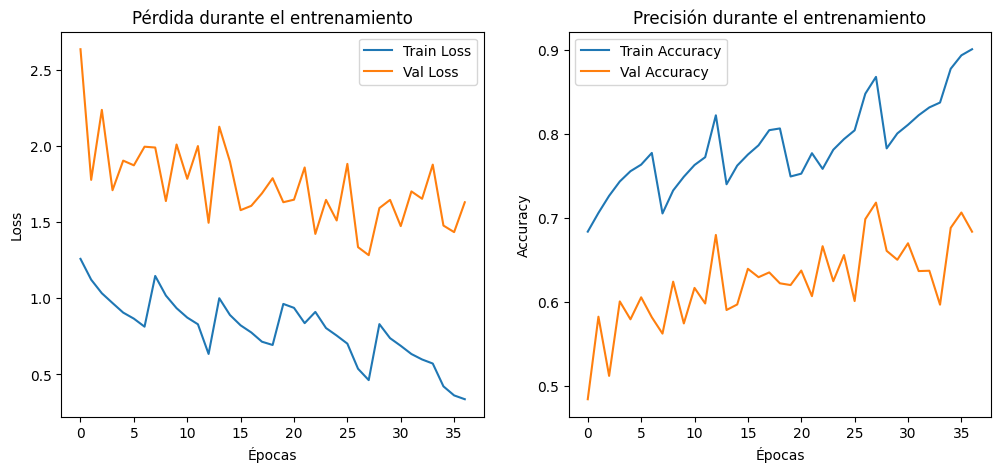

In [ ]:

ruta_historial = "/content/drive/MyDrive/tokio/deep_learning/proyecto_final_foodAi/mobilenet_food101_historial.json" #la ruta donde almacene toda la parte de entrenamiento

with open(ruta_historial, "r") as f:
    historial = json.load(f)

# Grafico el  entrenamiento
plt.figure(figsize=(12, 5))

#Gráfica de Loss
plt.subplot(1, 2, 1)
plt.plot(historial["loss"], label="Train Loss")
plt.plot(historial["val_loss"], label="Val Loss")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.title("Pérdida durante el entrenamiento")

# Gráfico Accuracy
plt.subplot(1, 2, 2)
plt.plot(historial["accuracy"], label="Train Accuracy")
plt.plot(historial["val_accuracy"], label="Val Accuracy")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Precisión durante el entrenamiento")

plt.show()


Las gráficas muestran que la pérdida de entrenamiento disminuye de forma estable, mientras que la pérdida de validación es más irregular, lo que sugiere posible sobreajuste. La precisión de entrenamiento mejora constantemente, pero la de validación fluctúa, indicando que el modelo no generaliza perfectamente. Para mejorar, se puede aumentar el Dropout, reducir la tasa de aprendizaje y usar EarlyStopping para evitar entrenar de más.

### Prediccion con una imagen de internet

Haremos una prueba con el modelo con algunas imágenes que cogeremos de internet. Para ello crearé una función para no reutilizar código que basicamente cogerá la imágen, la transformará para que el modelo la pueda reconocer (escalado, redimensión) , obtendré del resultado el nombre de la clase predicha accediendo a la posición del diccionario en el que se encuentra la clase, ya que el modelo de primeras predecirá el porcentaje más alto, luego cogeremos la posicion del porcentaje más alto y después lo transformaremos en el nombre del plato que ocupa esa posición en el diccionario con las clases

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


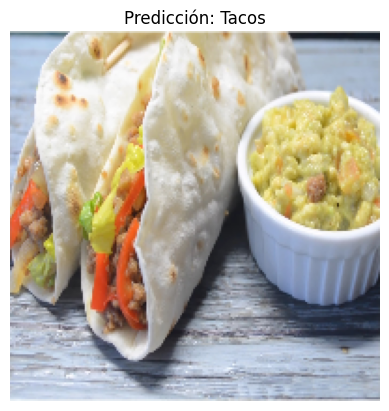

La imagen fue clasificada como: Tacos


In [17]:
import cv2


# Definir función para predecir una imagen
def predecir_imagen(ruta_imagen, modelo):
    """
    Carga una imagen, la procesa y la predice usando un modelo entrenado.
    Luego, muestra la imagen con la predicción.

    Parámetros:
    - ruta_imagen: str, ruta de la imagen a predecir.
    - modelo: modelo de deep learning ya entrenado.
    """
    # Cargo la imagen
    img = cv2.imread(ruta_imagen)
    if img is None:
        raise ValueError(f"No se pudo cargar la imagen en {ruta_imagen}")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (198, 198))  # Redimensiono al tamaño esperado por el modelo
    img_array = img / 255.0  # Normalizo
    img_array = np.expand_dims(img_array, axis=0)  # Expando dimensiones para la predicción

    # predicción
    prediccion = modelo.predict(img_array)
    clase_predicha = np.argmax(prediccion)  # Obtengo la clase con mayor probabilidad

    # Ruta del archivo labels.txt
    ruta_labels = "/content/drive/MyDrive/tokio/deep_learning/proyecto_final_foodAi/food-101/meta/labels.txt"

    # Verifico si el diccionario de clases ya existe, si no, crearlo
    ruta_clases = "/content/drive/MyDrive/tokio/deep_learning/proyecto_final_foodAi/clases_food101.npy"
    if not os.path.exists(ruta_clases):
        with open(ruta_labels, "r") as f:
            clases_lista = [line.strip() for line in f.readlines()]  # Leo y limpio nombres de clase

        diccionario_clases = {i: clase for i, clase in enumerate(clases_lista)}
        np.save(ruta_clases, diccionario_clases)  # Guardo el diccionario
        print(f"Diccionario de clases creado y guardado en {ruta_clases}")
    else:
        diccionario_clases = np.load(ruta_clases, allow_pickle=True).item()  # Cargo el diccionario

    # Obtengo el nombre de la clase predicha
    nombre_clase = diccionario_clases.get(clase_predicha, f"Clase {clase_predicha}")

    # Mouestro la imagen con la predicción
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicción: {nombre_clase}")
    plt.show()

    return nombre_clase

# Ejemplo de uso con una imagen
ruta_imagen = "/content/drive/MyDrive/tokio/deep_learning/proyecto_final_foodAi/imagenes_prueba/tacos.jpg"
nombre_predicho = predecir_imagen(ruta_imagen, modelo_mejor)
print(f"La imagen fue clasificada como: {nombre_predicho}")



In [20]:
ruta_imagen = "/content/drive/MyDrive/tokio/deep_learning/proyecto_final_foodAi/imagenes_prueba/hamburguesa.jpg"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


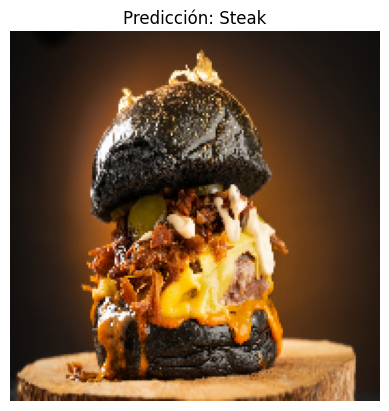

In [21]:
nombre_predicho = predecir_imagen(ruta_imagen, modelo_mejor) #aqui lo confundió con un filete

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


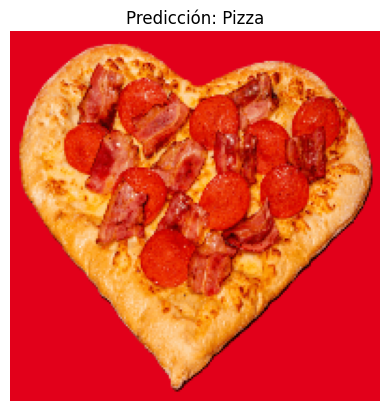

In [22]:
ruta_imagen = "/content/drive/MyDrive/tokio/deep_learning/proyecto_final_foodAi/imagenes_prueba/pizzacorazon.jpg"
nombre_predicho = predecir_imagen(ruta_imagen, modelo_mejor)

## **CONCLUSIONES DE ESTA PRIMERA PARTE**

Sin duda el modelo funciona bastante bien aunque podríamos haberlo mejorado mucho más:

-Entrenar con todo el conjunto

-Usar más ejemplos de data argumentation

-Redimensionar a 224x224 las imágenes para capturar más detalles

-Usar modelos preentrenados más robustos como ResNet o EficcientNet

-Congelar menos capas aún del modelo preentrenado para que aprenda más del problema que estamos tratando

Sin duda todo esto esta muy bien pero una de las mayores dificultades de esta parte fue entrenar el modelo ya que disponiamos de tantos datos que con nuestros recursos y tiempo no podemos permitirnos.

Sin duda fue de gran ayuda el uso de GPU pero era muy limitada aunque se consiguieron épocas más rapidas acelerando el entrenamiento bastante aunque en total fueron alrededor de unas 30 epocas. La idea de ir guardando el modelo con a medida que mejora el val_loss fue buena ya que se desconectaba el colab por el uso continuado y no podíamos permitirnos perder tanto tiempo, un tiempo por otro lado absurdo ya que la finalidad de esto es saber hasta donde podríamos llegar con todo esto y que quede una buena base sólida de cara a proyectos similares en empresas o con equipos que puedan abastecer problemas de esta embergadura

## FINAL DE LA PRIMERA PARTE DE CLASIFICACIÓN